In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import csv
import glob
import os

In [2]:
gs = {'torino': -196, 'fez': -246, 'kyiv': -194}

In [3]:
res = {}
for which in ['fez', 'kyiv', 'torino']:
    for ang in [16, 27, 'lin']:
        for les in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'neg.', 'pos.']:
            for p in range(50):
                fname = Path(f"./results/Hamiltonian_ibm_{which}_0/{ang}_{les}/{p=}/results.csv")
                try:
                    with open(fname, 'r') as f:
                        rd = csv.DictReader(f, delimiter=';', quotechar="'")
                        ind = (which, ang, les, p)
                        res[ind] = list(rd)
                except FileNotFoundError:
                    pass

                try:
                    fname = Path(f"./results/Hamiltonian_ibm_{which}_0/{ang}_{les}/{p=}/state_D=64.npy")
                    os.remove(fname)
                except FileNotFoundError:
                    pass
for k, v in res.items():
    for x in v:
        for kk in ["eng", "Delta", "chi", "D"]:
            x[kk] = float(x[kk])


In [4]:
def plot_energy_lin(ind):

    clrs = {"BP": 'blue', "CTM": 'red', 'MPS': 'green'}
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(5, 3)
    miny = 0
    maxy = -1000
    if ind in res:
        for pt in res[ind]:
            mrk = 'x' if pt["chi"] == 1 else '+'
            clr = clrs[pt["env"]]
            ax.scatter([1 / float(pt["D"])], float(pt["eng"]),
                        marker=mrk, color=clr, s=50)
            miny = min(miny, float(pt["eng"]))
            maxy = max(maxy, float(pt["eng"]))

        #ax.set_xscale('log')
        ax.set_xlabel('1 / D')
        ax.set_ylabel(f'eng')
        ax.set_ylim(miny-1, maxy+1)
        ax.set_xlim(0, 1)

        ax.grid(which='major')
        ax.grid(which='minor')
        ax.set_title(f'{ind}')

        ax.scatter([1.2], [1e-2], marker='+', color='black', s=50, label='chi>1')
        ax.scatter([1.2], [1e-2], marker='x', color='black', s=50, label='BP (chi=1)')
        for k, v in clrs.items():
            ax.scatter([1.2], [1e-2], marker='o', color=v, s=50, label=k)

        ax.legend()
    # plt.legend()
# plt.show()

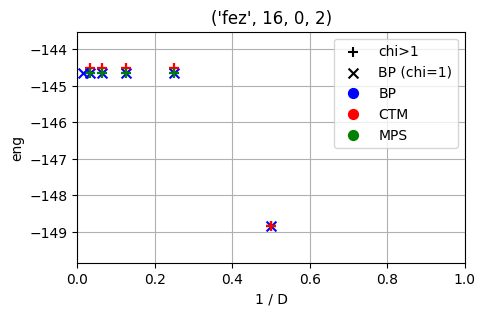

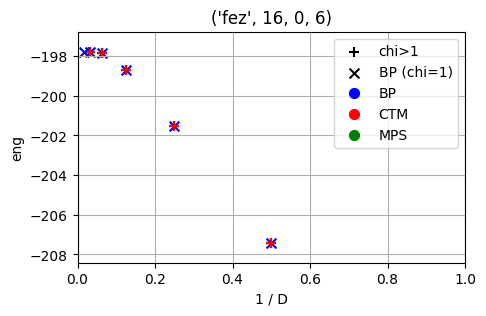

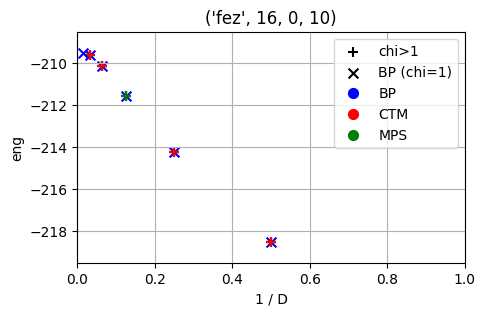

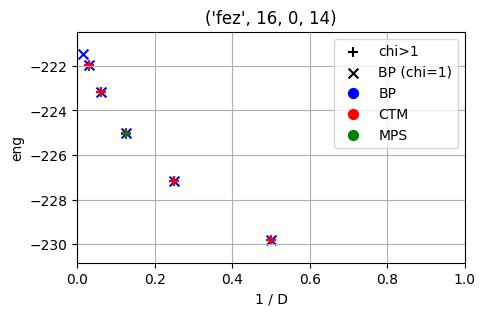

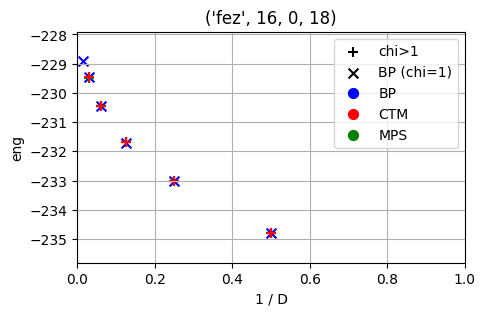

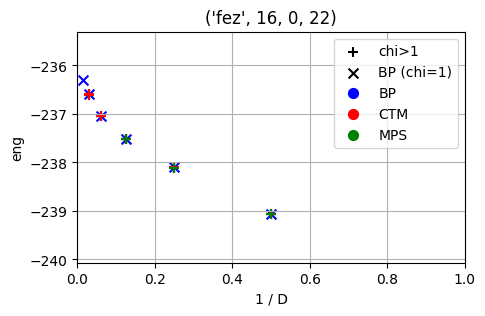

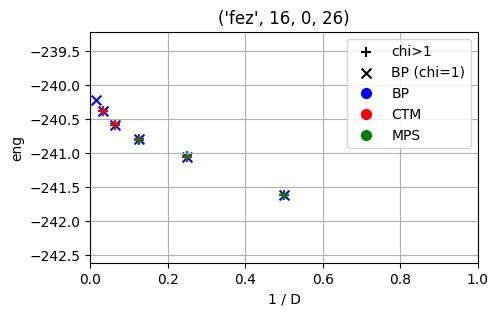

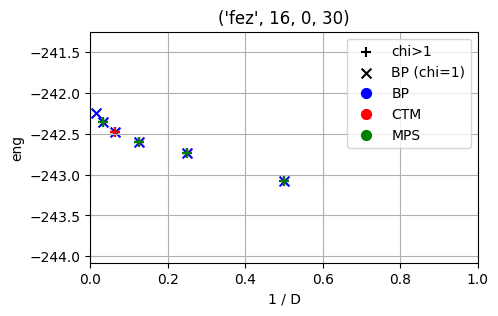

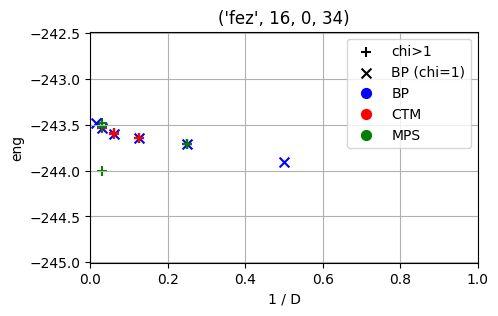

In [5]:
for p in range(2, 37, 4):
    plot_energy_lin(('fez', 16, 0, p))


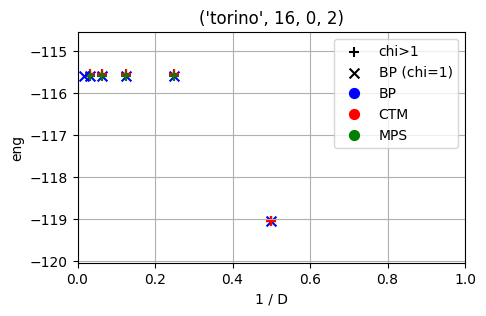

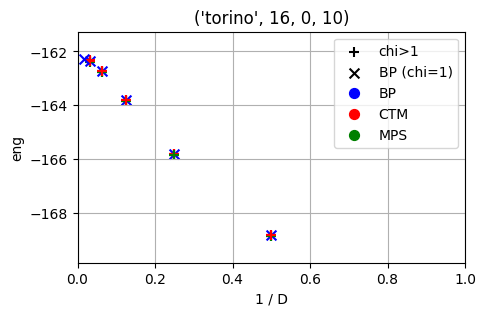

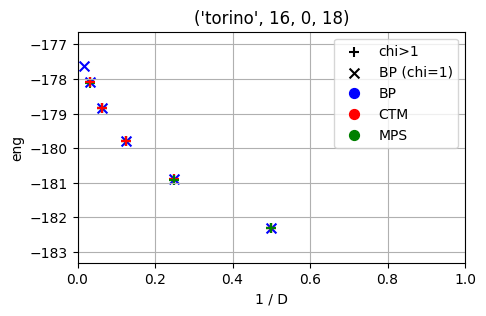

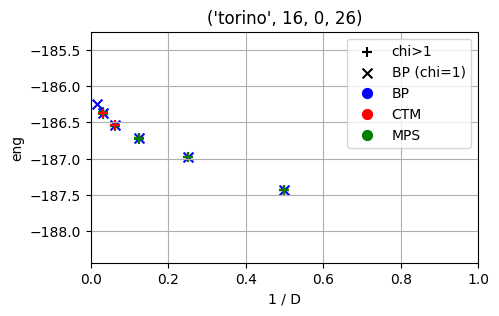

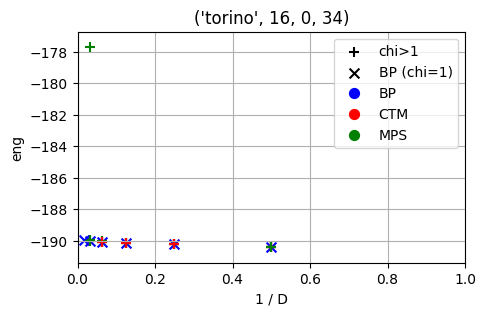

In [6]:
for p in range(2, 37, 8):
    plot_energy_lin(('torino', 16, 0, p))

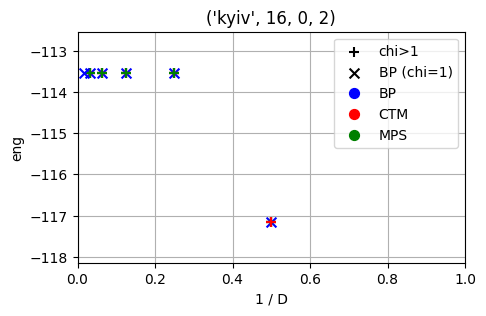

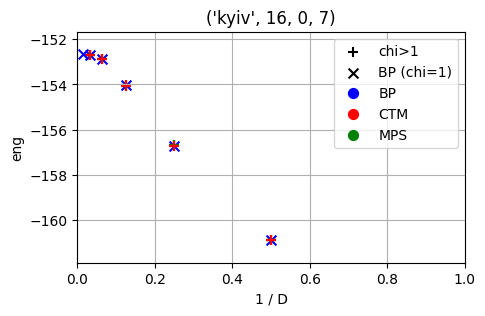

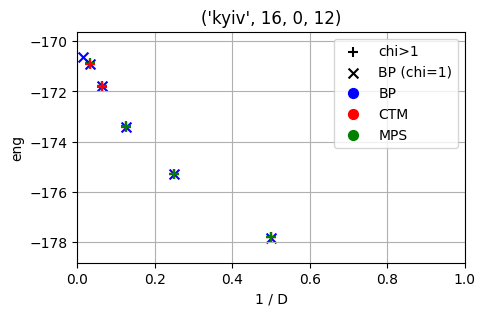

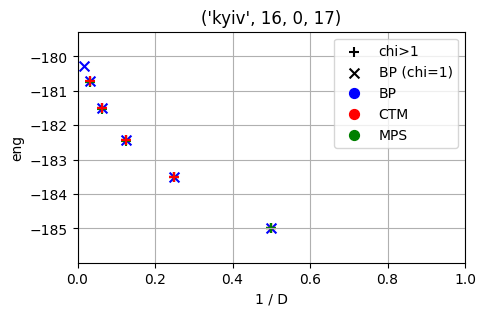

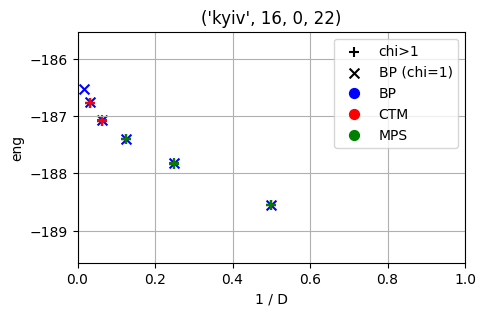

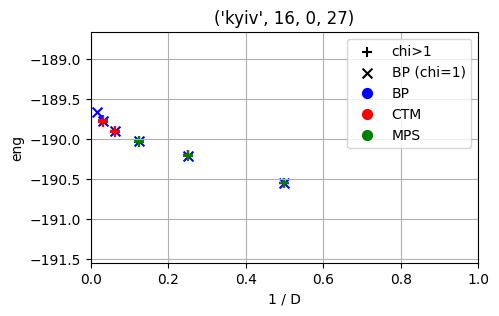

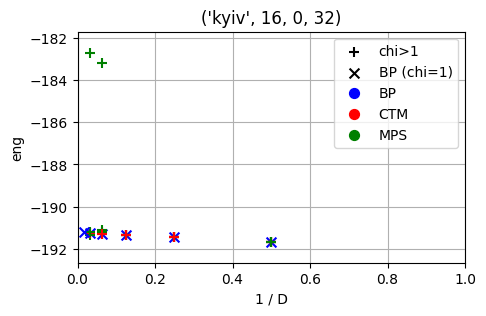

In [7]:
for p in range(2, 37, 5):
    plot_energy_lin(('kyiv', 16, 0, p))

In [8]:
def plot_energy_diff(which, ang, les):

    ps = list(range(4, 37))
    evs6432, evs3216= [], []
    for p in ps:
        ind = (which, ang, les, p)
        ev32, ev16, ev64 = 0, 0, 0
        
        for x in res[ind]:
            if x['D'] == 32 and x['env'] == 'BP':
                ev32 = float(x['eng'])
        
        for x in res[ind]:
            if x['D'] == 16 and x['env'] == 'BP':
                ev16 = float(x['eng'])

        for x in res[ind]:
            if x['D'] == 64 and x['env'] == 'BP':
                ev64 = float(x['eng'])
        
        
        evs6432.append((ev64-ev32) if ev64 < -10 else 0)    
        evs3216.append((ev64-ev16))    
    
    clrs = {'fez':'green', 'kyiv':'blue', 'torino':'red'}
    plt.plot(ps, evs6432, '-+', label=f"{which}, E(D=64) - E(D=32)", color=clrs[which])
    plt.plot(ps, evs3216, '-o', label=f"{which}, E(D=64) - E(D=16)", color=clrs[which])

    plt.xlabel('p')
    plt.ylabel(f'energy convergence')


    plt.legend()
    plt.show()

Compare energy (in BP) for D64, D32, D16;  [convergence with D]

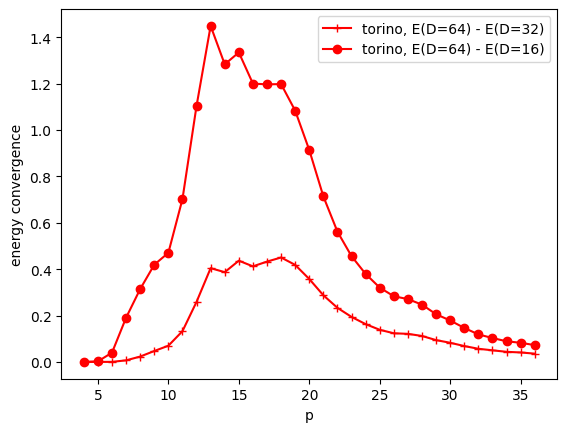

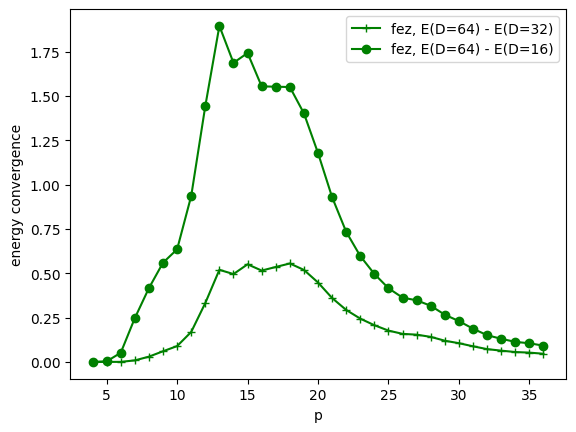

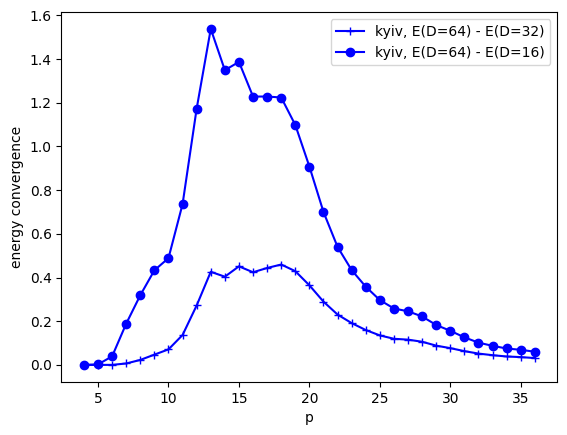

In [9]:
for which in gs:
    plot_energy_diff(which, 16, 0)


In [10]:
def plot_energy(which, ang, les):

    ps = list(range(4,37))
    evs = []
    for p in ps:
        ind = (which, ang, les, p)
        ev1 = 0
        for x in res[ind]:
            if x['D'] == 64 and x['env'] == 'BP':
                ev1 = float(x['eng'])
        evs.append(ev1)    

    evs = np.array(evs) - gs[which]
    plt.semilogy(ps, evs, '-+', label=f"{which}")

    plt.grid(visible=True, which='major', linestyle='-', axis='y')
    plt.grid(visible=True, which='minor', linestyle='--', axis='y')

    plt.xlabel('p')
    plt.ylabel(f'E_64 - E_GS')
    # plt.title(f"{which}, {ang}, {les}")
    plt.ylim([1, 100])
    plt.legend()
    plt.show()

Energy for D=32

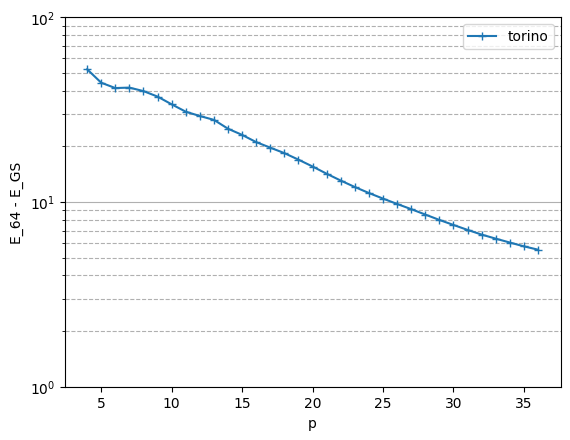

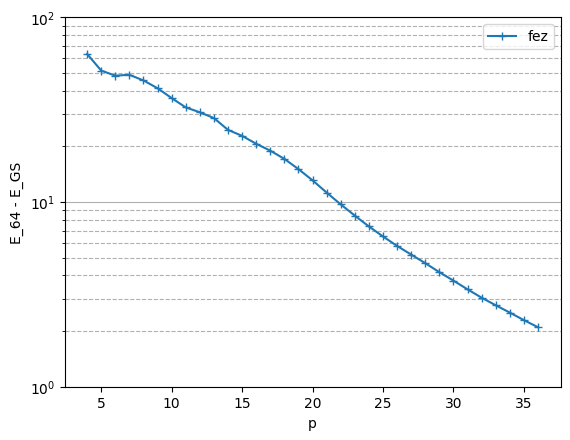

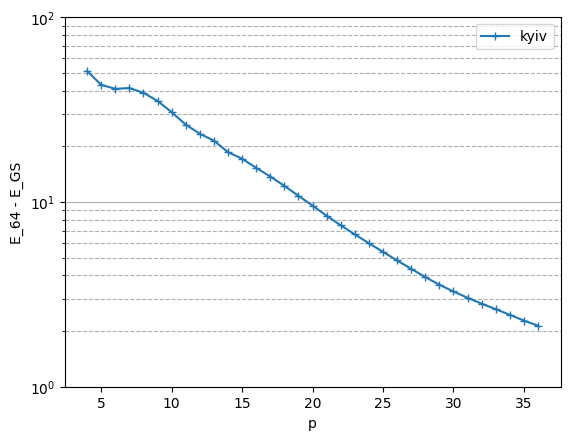

In [11]:
for which in gs:
    plot_energy(which, 16, 0)


In [12]:
def plot_contraction_comparison(ind):

    clrs = {"BP": 'blue', "CTM": 'red', 'MPS': 'green'}
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(5, 3)

    if ind in res:
        tmp = {(x['D'], x['env'], x['chi']): float(x['eng'])  for x in res[ind]}
        try:
            for D in [4, 8, 16, 32]:
                dE = tmp[(D, 'BP', 1)] - tmp[(D, 'MPS', 8)] 
                ax.scatter([1 / float(D)], abs(dE),
                            marker='+', color='b', s=100)
                
                dE = tmp[(D, 'BP', 1)] - tmp[(D, 'CTM', 8)] 
                ax.scatter([1 / float(D)], abs(dE),
                            marker='x', color='r', s=100)
        except KeyError:
            pass

    ax.set_yscale('log')
    ax.set_xlabel('1 / D')
    ax.set_ylabel(f'|E(MPS chi=8) - E(BP chi=1)|')
    ax.set_ylim(1e-6, 1e-0)
    ax.set_xlim(0, 0.26)

    ax.grid(which='major')
    ax.grid(which='minor')
    ax.set_title(f"{ind}")
    plt.show()

Here show convergence of energy (energy difference) between BP and MPS/CTM with chi=8

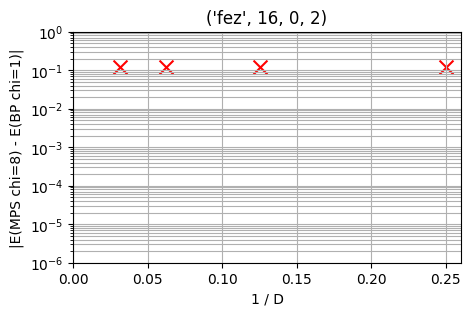

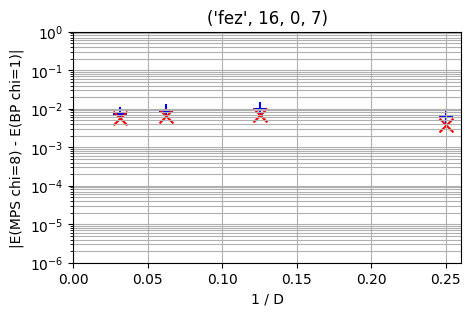

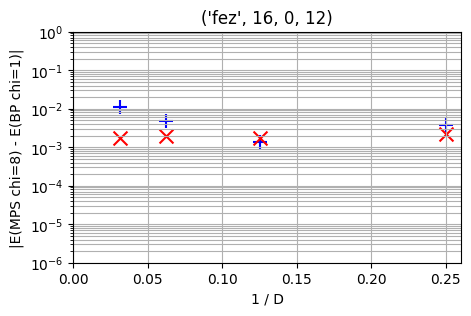

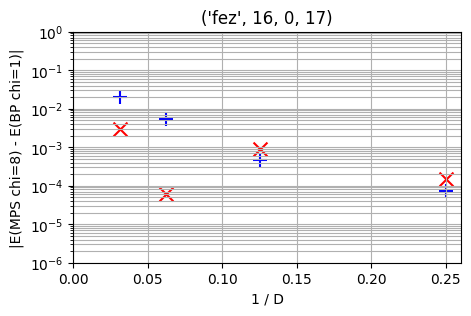

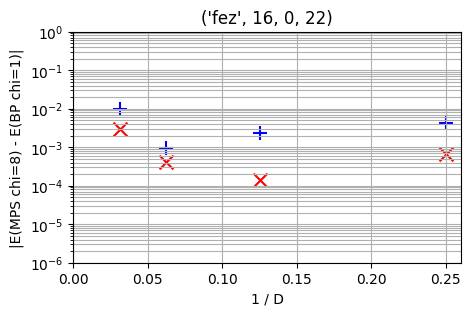

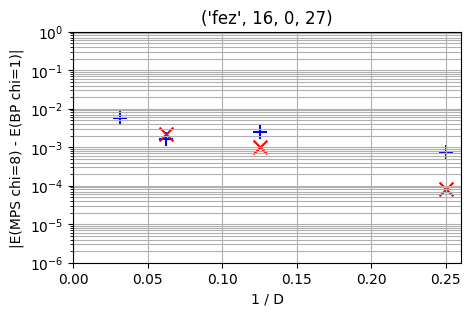

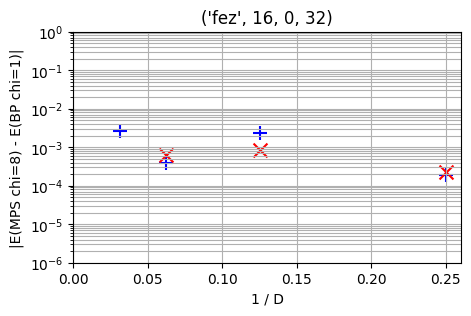

In [13]:
for p in range(2, 37, 5):
    plot_contraction_comparison(('fez', 16, 0, p))


In [14]:
smpls = {}
for which in ['fez', 'kyiv', 'torino']:
    for ang in [16]:
        for les in [0]:
            for p in range(37):
                for D in [8, 32]:
                    fname = Path(f"./results/Hamiltonian_ibm_{which}_0/{ang}_{les}/{p=}/samples_D={D}_CTM_chi=2.npy")
                    try:
                        ind = (which, ang, les, p, D)
                        smpls[ind] = np.load(fname, allow_pickle=True).item()
                    except FileNotFoundError:
                        pass

Text(0, 0.5, 'hits from 1000 samples')

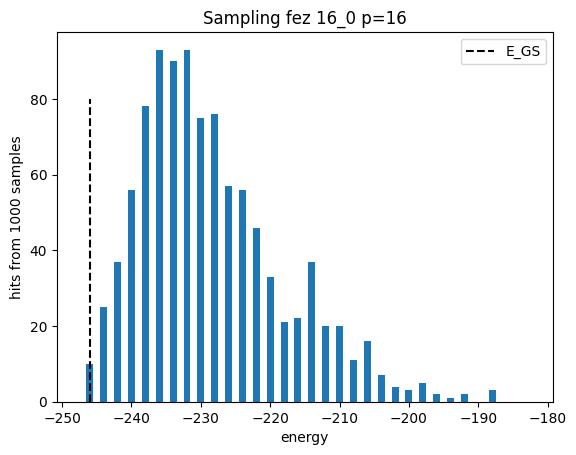

In [15]:
which = 'fez'
ee = smpls[(which, 16, 0, 16, 8)]['energies'].astype(np.int64)
bins=np.array(list(range(min(ee)-1, max(ee)+1) )) - 0.5
plt.hist(ee, bins=bins);
plt.plot([gs[which], gs[which]], [0, 80], '--k', label='E_GS')
plt.legend()
plt.title(f"Sampling {which} 16_0 p=16")
plt.xlabel("energy")
plt.ylabel("hits from 1000 samples")

In [16]:
for i in sorted(smpls):
    print(i)

('fez', 16, 0, 1, 8)
('fez', 16, 0, 1, 32)
('fez', 16, 0, 2, 8)
('fez', 16, 0, 2, 32)
('fez', 16, 0, 3, 8)
('fez', 16, 0, 3, 32)
('fez', 16, 0, 4, 8)
('fez', 16, 0, 4, 32)
('fez', 16, 0, 5, 8)
('fez', 16, 0, 6, 8)
('fez', 16, 0, 7, 8)
('fez', 16, 0, 8, 8)
('fez', 16, 0, 9, 8)
('fez', 16, 0, 10, 8)
('fez', 16, 0, 11, 8)
('fez', 16, 0, 12, 8)
('fez', 16, 0, 13, 8)
('fez', 16, 0, 14, 8)
('fez', 16, 0, 15, 8)
('fez', 16, 0, 16, 8)
('kyiv', 16, 0, 1, 8)
('kyiv', 16, 0, 1, 32)
('kyiv', 16, 0, 2, 8)
('kyiv', 16, 0, 2, 32)
('kyiv', 16, 0, 3, 8)
('kyiv', 16, 0, 3, 32)
('kyiv', 16, 0, 4, 8)
('kyiv', 16, 0, 4, 32)
('kyiv', 16, 0, 5, 8)
('kyiv', 16, 0, 6, 8)
('kyiv', 16, 0, 7, 8)
('kyiv', 16, 0, 8, 8)
('kyiv', 16, 0, 9, 8)
('kyiv', 16, 0, 10, 8)
('kyiv', 16, 0, 11, 8)
('kyiv', 16, 0, 12, 8)
('kyiv', 16, 0, 13, 8)
('kyiv', 16, 0, 14, 8)
('kyiv', 16, 0, 15, 8)
('kyiv', 16, 0, 16, 8)
('torino', 16, 0, 1, 8)
('torino', 16, 0, 1, 32)
('torino', 16, 0, 2, 8)
('torino', 16, 0, 2, 32)
('torino', 16, 0, 3,

In [17]:
dd = {which: {} for which in gs}
aa = {}
for which in gs:
    for ang in [16, 27, 'lin']:
        for les in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'neg.', 'pos.']:
            try:
                ind0 = (which, ang, les) 
                ind = max( [kk for kk in res.keys() if kk[0:3] == ind0])
                dd[which][ang, les] = max(xx["eng"] for xx in res[ind] if xx['env'] == 'BP')
                aa[ang, les] = ind[-1] 
            except ValueError:
                pass

In [18]:
def plot_best(which):
    x, y = [], []
    for k, v in dd[which].items():
        x.append(str(k))
        y.append(v)
    xx = list(range(len(y)))
    y=np.array(y)
    plt.plot(xx, y - gs[which], '-*', label=f"{which}")
    plt.grid(visible=True, axis='y', linestyle='--')
    plt.xticks(xx, x, rotation='vertical');
    # plt.plot([0, len(xx)], [gs[which]] * 2, '--k', label='GS')
    plt.legend()
    plt.ylabel("E(p=max) - E_GS")
    plt.ylim([0, 75])

def plot_max_p():
    x, y = [], []
    for k, v in aa.items():
        x.append(str(k))
        y.append(v)
    xx = list(range(len(y)))
    y=np.array(y)
    plt.plot(xx, y, '--*k', label=f"max p")
    plt.xticks(xx, x, rotation='vertical');
    plt.legend()

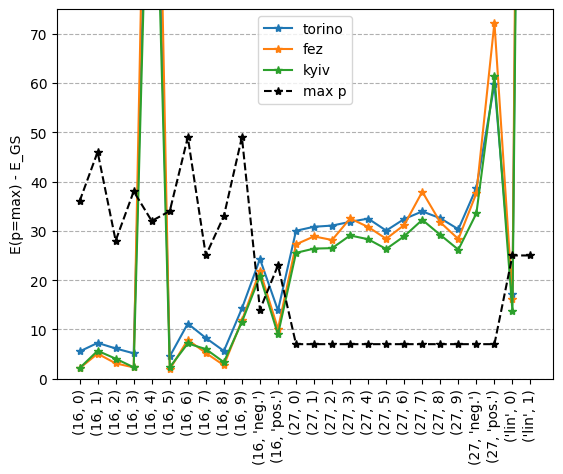

In [19]:
for which in gs:
    plot_best(which)
plot_max_p()